## Usecase: Predicting pedestrian numbers in Melbourne CBD
<hr>
<b>Applying Time Series methods to predict pedestrian numbers using the City of Melbourne's network of pedestrain sensors.</b>


This use case will explore different methods for predictive modelling with a time series.
Import sensor data
Prepare data
Create a baseline for comparison purposes

Train a univariate LSTM model
Make predictions, test model, save model

Then try different ways to prepare the data
Test again, save model

Then try adding extra data
Prepare data
Train a multivariate LSTM model
Make predictions, test model, save model

Look at alternatives to LSTM:
GRU, GRU hybrid
Random Forest Regressor
Sarima?

Investigate the possibility of seasonal adjustments

Create a visualisation where people can choose which sensor they want to predict


In [71]:
#Import all required packages

from math import sqrt
from numpy import concatenate
import numpy as np
from numpy import array

import keras
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, GRU
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import tensorflow as tf

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot as plt
# from sodapy import Socrata

import time
from datetime import datetime

# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

## How to do a time series analysis, using the City of Melbourne's pedestrian sensor network data
<hr>
For this example, we will begin by grabbing the dataset. We'll only look at one of the sensors to begin with.

In [2]:
# # Uncomment the below to open data source, download sensor data, and store it as a csv locally.

# #Function to get Sensor count history data
# def sensor_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     sensor_data_id = "b2ak-trbp"
#     results = client.get(sensor_data_id, limit=5000000)
#     df = pd.DataFrame.from_records(results)
#     df = df[['date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id', 'sensor_name', 'hourly_counts']]
#     return df

# sensor_history = sensor_count()

# sensor_history.to_csv('sensor_history.csv', index=False)

In [2]:
sensor_history = pd.read_csv('sensor_history.csv')

In [3]:
single_sensor = sensor_history[sensor_history.sensor_id == 4].copy()
single_sensor.sort_values('date_time', inplace=True, ascending=True)

<b>Let's do a quick visualisation:</b>

We create a quick chart here, with the date on the x-axis, and the hourly counts on the y-axis.

There are a few immediate observations: 
Firstly, there is a missing chunk of data around the year 2017.
Secondly, the overall pattern has some dramatic changes in early 2020, coinciding with the arrival of Covid-19.
Thirdly there are some potential outliers, for example an hourly count of 8000 in the year 2010.

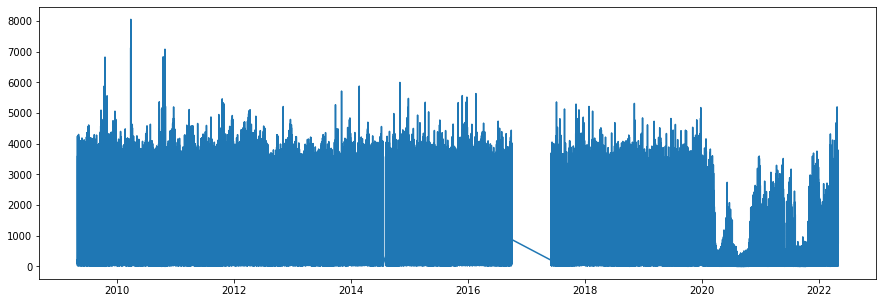

In [4]:
subset = single_sensor[['date_time', 'hourly_counts']].copy()
subset.date_time = pd.to_datetime(subset.date_time)
plt.figure(figsize = (15, 5))
plt.plot(subset.date_time, subset.hourly_counts)

<b>Create a baseline:</b>

Now, it is important to understand that a model that attempts to make predictions on a time series can have reasonably good success by simply copying the value of the previous time step. In most cases, this value will be close to the next value in the sequence - and this can give the appearance of predictive ability where there is actually none.

For example, if a sensor has 100 pedestrians recorded between 2am to 3am, then it is likely that the number of pedestrians recorded between 3am and 4am won't be too much more or less than 100. So a model that simply predicted '100' in this case would have reasonable accuracy. 

So before building models and evaluating them, it is worthwhile setting up a baseline. This is the performance attained by simply copying the hourly count from the previous time step.

In [6]:
true_count = single_sensor.hourly_counts.to_numpy()
prev_count = true_count[1:true_count.shape[0]]
r2_baseline = r2_score(prev_count, true_count[0:true_count.shape[0]-1])   
print("The baseline R-squared score is:", r2_baseline)

The baseline R-squared score is: 0.8835439180056677


From this example we can see a fairly convincing score (at the time of writing this comment, it was around 0.884). However, we know that the model we just made is useless for our purposes.
We need to improve on this score!

<b>Preparing the data:</b>

The first thing we will do is a simple kind of scaling on the 'hourly_counts'. Later, when we look at multivariate LSTM, we will use different methods of scaling the data.

In [4]:
#Make sensor counts range from 0 to 1.
maximum = single_sensor.hourly_counts.max()
single_sensor['hourly_counts'] = single_sensor['hourly_counts']/maximum

In [5]:
sensor_seq = []
for i in range(0, len(single_sensor)):
    sensor_seq.append(single_sensor.hourly_counts.iloc[i])

In [9]:
#This code is copied almost verbatim from the website 'Machine Learning Mastery'
#which is ne of my favourite sites to learn about machine learning!

# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# choose a number of time steps
n_steps = 168
# split into samples
X, y = split_sequence(sensor_seq, n_steps)


In [10]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [25]:
#These next three chunks of code use different sections of the dataset.
#Using the whole dataset takes much longer to train.
#Using the earliest sections means using data unaffected by coronavirus. This may be
#more accurate in the long run.
#Using the latest sections means using data affected by coronavirus. This may be more
#accurate while coronavirus is still having an impact.

#This next code will split the entire dataset. In practice, this took a long time to train.

# X_train = X[10001:80000]
# X_val = X[80001:]
# X_test = X[:10000]
# Y_train = y[10001:80000]
# Y_val = y[80001:]
# Y_test = y[:10000]

#This uses a subset of the dataset, from near the beginning of the time series.

# X_train = X[15001:25000]
# X_val = X[25001:30000]
# X_test = X[5000:10000]
# Y_train = y[15001:25000]
# Y_val = y[25001:30000]
# Y_test = y[5000:10000]

#This uses a subset of the dataset, from near the end of the time series.

X_train = X[85001:105000]
X_val = X[75001:85000]
X_test = X[65000:75000]
Y_train = y[85001:105000]
Y_val = y[75001:85000]
Y_test = y[65000:75000]

In [26]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(48, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(96, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='mse')

In [27]:
# fit model
history = model.fit(X_train, Y_train, validation_data =(X_val, Y_val), epochs=45, verbose=1, batch_size = 64)

Epoch 1/45
313/313 [==============================] - 35s 79ms/step - loss: 0.1363 - val_loss: 0.0470
Epoch 2/45
313/313 [==============================] - 24s 78ms/step - loss: 0.0152 - val_loss: 0.0236
Epoch 3/45
313/313 [==============================] - 28s 88ms/step - loss: 0.0116 - val_loss: 0.0230
Epoch 4/45
313/313 [==============================] - 51s 163ms/step - loss: 0.0106 - val_loss: 0.0226
Epoch 5/45
313/313 [==============================] - 127s 408ms/step - loss: 0.0101 - val_loss: 0.0220
Epoch 6/45
313/313 [==============================] - 20s 64ms/step - loss: 0.0096 - val_loss: 0.0203
Epoch 7/45
313/313 [==============================] - 23s 75ms/step - loss: 0.0088 - val_loss: 0.0167
Epoch 8/45
313/313 [==============================] - 41s 130ms/step - loss: 0.0065 - val_loss: 0.0077
Epoch 9/45
313/313 [==============================] - 44s 139ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 10/45
313/313 [==============================] - 34s 110ms/step - loss:

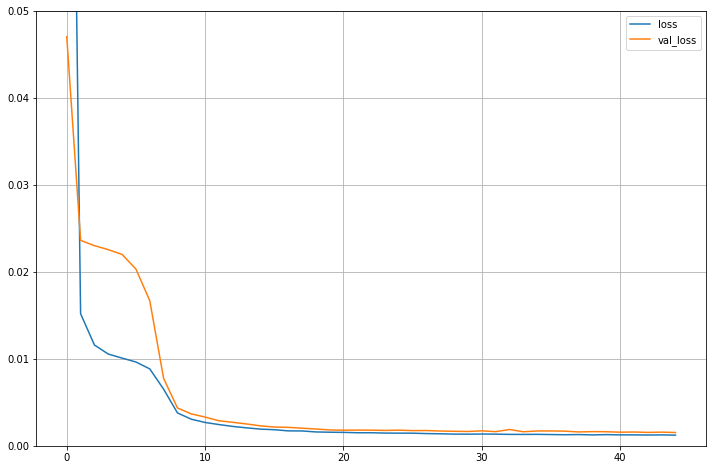

In [28]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0, 0.05)
plt.show()

In [29]:
# demonstrate prediction
x_input = array(sensor_seq[1001:1001+n_steps])

x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print("predicted next value: ", yhat  * maximum)
print("actual next value: ", sensor_seq[1001+n_steps] * maximum)

predicted next value:  [[2920.0583]]
actual next value:  3115.0


In [30]:
# demonstrate prediction
x_input = array(sensor_seq[80001:80001+n_steps])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print("predicted next value: ", yhat  * maximum)
print("actual next value: ", sensor_seq[80001+n_steps] * maximum)

predicted next value:  [[3167.7036]]
actual next value:  3338.0


In [31]:
pred = model.predict(X_test)
first_score = r2_score(Y_test, pred)
print("The first R-squared score we have attained is:", first_score)

313/313 [==============================] - 9s 29ms/step
The first R-squared score we have attained is: 0.9287348082357268


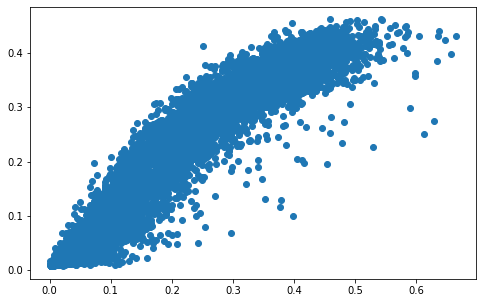

In [32]:
#Now let us visualise the predicted values against the actual values:
plt.figure(figsize=(8,5))
plt.scatter(Y_test, pred)
plt.show()

In [33]:
#Save the model:
model.save("LSTM_univariate.h5")

##### In this section, we will look at adding different datasets and performing mulitvariate LSTM

In [22]:
# #Function to get Sensor count history data
# def micro_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     micro_data_id = "u4vh-84j8"
#     results = client.get(micro_data_id, limit=4000000)
#     if results:
#         df = pd.DataFrame.from_records(results)
#     return df

# micro_history = micro_count()

# micro_history.to_csv('micro_history.csv', index=False)

In [6]:
micro_history = pd.read_csv('micro_history.csv')

micro_history = micro_history[(micro_history.sensor_id == '5a') | (micro_history.sensor_id == '5b') |
                             (micro_history.sensor_id == '5c') | (micro_history.sensor_id == '0a') |
                             (micro_history.sensor_id == '0b') | (micro_history.sensor_id == '6')]

micro_history = micro_history[(micro_history.site_id == 1003) | (micro_history.site_id == 1009)]

micro_history = micro_history.drop(['id', 'gateway_hub_id', 'type', 'units'], axis=1)

micro_history.loc[micro_history.sensor_id == '5a', 'temp'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '5b', 'humidity'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '5c', 'pressure'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '0a', 'part_2p5'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '0b', 'part_10'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '6', 'wind'] = micro_history.value

micro_history.local_time = pd.to_datetime(micro_history.local_time, format='%Y-%m-%d')
micro_history['year'] = micro_history.local_time.dt.year
micro_history['month'] = micro_history.local_time.dt.month_name()
micro_history['mdate'] = micro_history.local_time.dt.day
micro_history['time'] = micro_history.local_time.dt.hour

micro_history = micro_history.drop(['site_id', 'sensor_id', 'value', 'local_time'], axis=1)
micro_history = micro_history.groupby(by=['year', 'month', 'mdate', 'time']).max()

ped_climate = sensor_history.merge(micro_history, on=('year', 'month', 'mdate', 'time'), how='inner')

In [7]:
single_sensor_climate = ped_climate.loc[ped_climate.sensor_name == 'Town Hall (West)'].copy()

In [8]:
single_sensor_climate.fillna(method='ffill', inplace = True)

In [43]:
single_sensor_climate.head()

,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,temp,humidity,pressure,part_2p5,part_10,wind
512,2019-11-15T09:00:00.000,2019,November,15,Friday,9,4,Town Hall (West),1430,15.41,66.14,1008.0,4.5,18.4,7.92
567,2019-11-15T10:00:00.000,2019,November,15,Friday,10,4,Town Hall (West),2101,16.12,59.41,1008.0,4.2,20.0,7.88
622,2019-11-15T11:00:00.000,2019,November,15,Friday,11,4,Town Hall (West),2577,16.90,57.53,1007.9,4.1,20.1,7.92
677,2019-11-15T12:00:00.000,2019,November,15,Friday,12,4,Town Hall (West),3439,18.73,54.64,1007.5,4.5,23.1,9.68
732,2019-11-15T13:00:00.000,2019,November,15,Friday,13,4,Town Hall (West),4043,18.78,51.06,1006.7,4.1,18.7,10.44


In [44]:
single_sensor_climate.drop(['date_time', 'year', 'sensor_id', 'sensor_name', 'mdate'], axis = 1, inplace = True)

In [45]:
month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

In [46]:
single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [57]:
single_sensor_climate.head()

,month,day,time,hourly_counts,temp,humidity,pressure,part_2p5,part_10,wind
512,11,5,9,1430,15.41,66.14,1008.0,4.5,18.4,7.92
567,11,5,10,2101,16.12,59.41,1008.0,4.2,20.0,7.88
622,11,5,11,2577,16.90,57.53,1007.9,4.1,20.1,7.92
677,11,5,12,3439,18.73,54.64,1007.5,4.5,23.1,9.68
732,11,5,13,4043,18.78,51.06,1006.7,4.1,18.7,10.44


In [48]:
scaler = MinMaxScaler()

In [49]:
scaled = scaler.fit_transform(single_sensor_climate)

In [50]:
new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

In [51]:
for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:9] = scaled[i][0:9]
    new_sequence[i][10] = scaled[i+1][3]

In [88]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

In [89]:
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

In [90]:
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [103]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [106]:
model.fit(train_x, train_y, validation_data = (test_x, test_y), epochs=500, verbose=1, batch_size = 64)

Epoch 1/500
188/188 [==============================] - 5s 27ms/step - loss: 0.1449 - val_loss: 0.1355
Epoch 2/500
188/188 [==============================] - 6s 29ms/step - loss: 0.1234 - val_loss: 0.1109
Epoch 3/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0912 - val_loss: 0.0812
Epoch 4/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0631 - val_loss: 0.0571
Epoch 5/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0433 - val_loss: 0.0404
Epoch 6/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0305 - val_loss: 0.0293
Epoch 7/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0216 - val_loss: 0.0216
Epoch 8/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0167 - val_loss: 0.0169
Epoch 9/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 10/500
188/188 [==============================] - 5s 26ms/step - loss: 0.011

188/188 [==============================] - 5s 29ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 160/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 161/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 162/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 163/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 164/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 165/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 166/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 167/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 168/500
188/188 [==============================] - 5s 25ms/step - loss: 

Epoch 238/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 239/500
188/188 [==============================] - 5s 29ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 240/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 241/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 242/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 243/500
188/188 [==============================] - 5s 29ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 244/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 245/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 246/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 247/500
188/188 [==============================] - 5s 26ms

Epoch 317/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 318/500
188/188 [==============================] - 5s 29ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 319/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 320/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 321/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 322/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 323/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 324/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 325/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 326/500
188/188 [==============================] - 5s 26ms

Epoch 474/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 475/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 476/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 477/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 478/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 479/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 480/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 481/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 482/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 483/500
188/188 [==============================] - 5s 28ms

In [107]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

89/89 [==============================] - 1s 12ms/step
R-squared score: 0.938


In [108]:
#Save the model:
model.save("LSTM_multivariate_1.h5")

In [115]:
#What about if we try one hot encoding instead?
single_sensor_climate = ped_climate.loc[ped_climate.sensor_name == 'Town Hall (West)'].copy()
single_sensor_climate.fillna(method='ffill', inplace = True)

month_dummies = pd.get_dummies(single_sensor_climate.month)
day_dummies = pd.get_dummies(single_sensor_climate.day)

In [116]:
single_sensor_climate.drop(['date_time', 'month', 'day', 'year', 'sensor_id', 'sensor_name', 'mdate'], axis = 1, inplace = True)

In [117]:
single_sensor_climate = pd.concat([single_sensor_climate, month_dummies, day_dummies], axis = 1)

In [118]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:26] = scaled[i][0:26]
    new_sequence[i][27] = scaled[i+1][1]  


In [119]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [120]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [121]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=1, batch_size = 64)

Epoch 1/500
188/188 [==============================] - 16s 37ms/step - loss: 0.1640 - val_loss: 0.1584
Epoch 2/500
188/188 [==============================] - 6s 30ms/step - loss: 0.1629 - val_loss: 0.1572
Epoch 3/500
188/188 [==============================] - 6s 33ms/step - loss: 0.1614 - val_loss: 0.1556
Epoch 4/500
188/188 [==============================] - 7s 35ms/step - loss: 0.1591 - val_loss: 0.1529
Epoch 5/500
188/188 [==============================] - 22s 119ms/step - loss: 0.1548 - val_loss: 0.1477
Epoch 6/500
188/188 [==============================] - 15s 81ms/step - loss: 0.1458 - val_loss: 0.1368
Epoch 7/500
188/188 [==============================] - 11s 59ms/step - loss: 0.1273 - val_loss: 0.1156
Epoch 8/500
188/188 [==============================] - 6s 34ms/step - loss: 0.0979 - val_loss: 0.0860
Epoch 9/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0686 - val_loss: 0.0614
Epoch 10/500
188/188 [==============================] - 7s 40ms/step - loss: 

188/188 [==============================] - 6s 31ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 160/500
188/188 [==============================] - 5s 29ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 161/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 162/500
188/188 [==============================] - 6s 31ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 163/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 164/500
188/188 [==============================] - 6s 29ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 165/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 166/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 167/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 168/500
188/188 [==============================] - 5s 29ms/step - loss: 

Epoch 238/500
188/188 [==============================] - 7s 35ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 239/500
188/188 [==============================] - 7s 37ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 240/500
188/188 [==============================] - 13s 71ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 241/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 242/500
188/188 [==============================] - 9s 51ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 243/500
188/188 [==============================] - 6s 34ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 244/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 245/500
188/188 [==============================] - 6s 33ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 246/500
188/188 [==============================] - 16s 87ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 247/500
188/188 [==============================] - 6s 32

Epoch 395/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 396/500
188/188 [==============================] - 5s 29ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 397/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 398/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 399/500
188/188 [==============================] - 5s 29ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 400/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 401/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 402/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 403/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 404/500
188/188 [==============================] - 5s 26ms

Epoch 474/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 475/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 476/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 477/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 478/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 479/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 480/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 481/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 482/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 483/500
188/188 [==============================] - 5s 25ms

In [123]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

89/89 [==============================] - 1s 14ms/step
R-squared score: 0.923


##### That didn't improve the model. Let's try adding more datasets and see if we can improve things. 

In [9]:
#What about if we add more datasets?
combined = pd.read_csv('combined.csv')

In [10]:
combo_climate = ped_climate.merge(combined, on=('year', 'month', 'mdate', 'time', 'sensor_id',
                                                'day', 'sensor_name', 'hourly_counts'), how='inner')

In [126]:
single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [127]:
single_sensor_climate.drop(['date_time_x', 'date_time_y', 'year', 'sensor_id', 'sensor_name'
                            , 'lat', 'lon', 'sensor_description', 'mdate'], axis = 1, inplace = True)

In [128]:
single_sensor_climate.fillna(method='ffill', inplace = True)

In [129]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:15] = scaled[i][0:15]
    new_sequence[i][16] = scaled[i+1][3]

In [130]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [131]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')


In [132]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=1, batch_size = 64)

Epoch 1/500
188/188 [==============================] - 16s 43ms/step - loss: 0.1639 - val_loss: 0.1583
Epoch 2/500
188/188 [==============================] - 6s 34ms/step - loss: 0.1627 - val_loss: 0.1569
Epoch 3/500
188/188 [==============================] - 6s 31ms/step - loss: 0.1609 - val_loss: 0.1549
Epoch 4/500
188/188 [==============================] - 5s 27ms/step - loss: 0.1578 - val_loss: 0.1511
Epoch 5/500
188/188 [==============================] - 5s 25ms/step - loss: 0.1514 - val_loss: 0.1428
Epoch 6/500
188/188 [==============================] - 5s 27ms/step - loss: 0.1368 - val_loss: 0.1239
Epoch 7/500
188/188 [==============================] - 5s 26ms/step - loss: 0.1083 - val_loss: 0.0936
Epoch 8/500
188/188 [==============================] - 9s 45ms/step - loss: 0.0751 - val_loss: 0.0660
Epoch 9/500
188/188 [==============================] - 10s 54ms/step - loss: 0.0515 - val_loss: 0.0486
Epoch 10/500
188/188 [==============================] - 9s 50ms/step - loss: 0.0

188/188 [==============================] - 8s 43ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 160/500
188/188 [==============================] - 10s 54ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 161/500
188/188 [==============================] - 6s 31ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 162/500
188/188 [==============================] - 6s 29ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 163/500
188/188 [==============================] - 9s 48ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 164/500
188/188 [==============================] - 9s 46ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 165/500
188/188 [==============================] - 6s 31ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 166/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 167/500
188/188 [==============================] - 7s 39ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 168/500
188/188 [==============================] - 5s 28ms/step - loss:

Epoch 238/500
188/188 [==============================] - 5s 29ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 239/500
188/188 [==============================] - 5s 29ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 240/500
188/188 [==============================] - 5s 29ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 241/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 242/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 243/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 244/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 245/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 246/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 247/500
188/188 [==============================] - 5s 25ms

Epoch 317/500
188/188 [==============================] - 6s 31ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 318/500
188/188 [==============================] - 6s 29ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 319/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 320/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 321/500
188/188 [==============================] - 6s 31ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 322/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 323/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 324/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 325/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 326/500
188/188 [==============================] - 5s 24ms

Epoch 396/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 397/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 398/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 399/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 400/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 401/500
188/188 [==============================] - 6s 31ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 402/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 403/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 404/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 405/500
188/188 [==============================] - 5s 26ms

In [133]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

89/89 [==============================] - 3s 11ms/step
R-squared score: 0.936


In [134]:
#Save the model:
model.save("LSTM_multivariate_2.h5")

##### We still seem to be having trouble trying to break through to a better model. What about adding more data?

In [11]:
rainfall_data = pd.read_csv('rainfall.csv')

In [12]:
rainfall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  25675 non-null  object 
 1   rainfall  25675 non-null  float64
dtypes: float64(1), object(1)
memory usage: 401.3+ KB


In [13]:
rainfall_data.datetime = pd.to_datetime(rainfall_data.datetime, format='%d/%m/%Y %H:%M')
rainfall_data['year'] = rainfall_data.datetime.dt.year
rainfall_data['month'] = rainfall_data.datetime.dt.month_name()
rainfall_data['mdate'] = rainfall_data.datetime.dt.day
rainfall_data['time'] = rainfall_data.datetime.dt.hour

In [14]:
single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

# single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [15]:
rain_combo_single_sensor = single_sensor_climate.merge(rainfall_data, on=('year', 'month'
                                                        , 'mdate', 'time',), how='inner')

In [16]:
rain_combo_single_sensor.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [17]:
rain_combo_single_sensor.drop(['date_time_x', 'date_time_y', 'year', 'sensor_id'
                               , 'sensor_name', 'lat', 'lon', 'sensor_description'
                               , 'mdate', 'datetime'], axis = 1, inplace = True)

In [176]:
rain_combo_single_sensor.fillna(method='ffill', inplace = True)

In [180]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(rain_combo_single_sensor)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:16] = scaled[i][0:16]
    new_sequence[i][17] = scaled[i+1][3]

In [188]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [189]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [190]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=1, batch_size = 64)

Epoch 1/500
188/188 [==============================] - 16s 40ms/step - loss: 0.1641 - val_loss: 0.1582
Epoch 2/500
188/188 [==============================] - 5s 29ms/step - loss: 0.1630 - val_loss: 0.1570
Epoch 3/500
188/188 [==============================] - 6s 33ms/step - loss: 0.1615 - val_loss: 0.1553
Epoch 4/500
188/188 [==============================] - 5s 26ms/step - loss: 0.1590 - val_loss: 0.1519
Epoch 5/500
188/188 [==============================] - 7s 35ms/step - loss: 0.1538 - val_loss: 0.1439
Epoch 6/500
188/188 [==============================] - 6s 31ms/step - loss: 0.1416 - val_loss: 0.1253
Epoch 7/500
188/188 [==============================] - 4s 24ms/step - loss: 0.1165 - val_loss: 0.0926
Epoch 8/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0840 - val_loss: 0.0611
Epoch 9/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0573 - val_loss: 0.0404
Epoch 10/500
188/188 [==============================] - 4s 23ms/step - loss: 0.03

Epoch 159/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 160/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 161/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 162/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 163/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 164/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 165/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 166/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 167/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 168/500
188/188 [==============================] - 5s 24ms

Epoch 238/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 239/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 240/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 241/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 242/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 243/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 244/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 245/500
188/188 [==============================] - 6s 31ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 246/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 247/500
188/188 [==============================] - 4s 21ms

Epoch 317/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 318/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 319/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 320/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 321/500
188/188 [==============================] - 7s 38ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 322/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 323/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 324/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 325/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 326/500
188/188 [==============================] - 4s 23ms

Epoch 396/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 397/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 398/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 399/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 400/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 401/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 402/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 403/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 404/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 405/500
188/188 [==============================] - 4s 24ms

Epoch 475/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 476/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 477/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 478/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 479/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 480/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 481/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 482/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 483/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 484/500
188/188 [==============================] - 4s 23ms

In [191]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

89/89 [==============================] - 3s 11ms/step
R-squared score: 0.936


In [192]:
#Save the model:
model.save("LSTM_multivariate_3.h5")

In [18]:
#Lets try adding some more data!
#We'll recreate the rainfall dataset...

single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

rain_combo_single_sensor = single_sensor_climate.merge(rainfall_data, on=('year', 'month'
                                                        , 'mdate', 'time',), how='inner')

lockdown_combo = rain_combo_single_sensor.copy()

In [19]:
# https://lockdownstats.melbourne/timeline/
lockdowns = (['2020-03-31T23:59', '2020-05-31T23:59'], #lockdown 1
            ['2020-07-08T23:59', '2020-10-27T23:59'], #lockdown 2
            ['2021-02-12T23:59', '2021-02-17T23:59'], #lockdown 3
            ['2021-05-27T23:59', '2021-06-10T23:59'], #lockdown 4
            ['2021-07-15T23:59', '2021-07-27T23:59'], #lockdown 5
            ['2021-08-05T19:59', '2021-10-21T23:59']) #lockdown 6

lockdown_combo[['lockdown']] = 0

In [20]:
for i in range (0, len(lockdowns)):
    start = lockdowns[i][0]
    end = lockdowns[i][1]
    lockdown_combo['lockdown'] = np.where((lockdown_combo['date_time_x'] > start)
                                               & (lockdown_combo['date_time_x'] < end), 1, 0)

In [22]:
lockdown_combo.replace({'month': month_dict, 'day': day_dict}, inplace = True)
saved_for_later = lockdown_combo.copy()

In [279]:
lockdown_combo.drop(['date_time_x', 'date_time_y', 'year', 'sensor_id', 'datetime'
                               , 'sensor_name', 'lat', 'lon', 'sensor_description'
                               , 'mdate', 'datetime'], axis = 1, inplace = True)

In [280]:
lockdown_combo.fillna(method='ffill', inplace = True)

In [281]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(lockdown_combo)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:17] = scaled[i][0:17]
    new_sequence[i][18] = scaled[i+1][3]

In [270]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [271]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [272]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=1, batch_size = 64)

Epoch 1/500
188/188 [==============================] - 31s 113ms/step - loss: 0.1640 - val_loss: 0.1581
Epoch 2/500
188/188 [==============================] - 19s 103ms/step - loss: 0.1629 - val_loss: 0.1568
Epoch 3/500
188/188 [==============================] - 21s 111ms/step - loss: 0.1613 - val_loss: 0.1550
Epoch 4/500
188/188 [==============================] - 18s 94ms/step - loss: 0.1586 - val_loss: 0.1515
Epoch 5/500
188/188 [==============================] - 17s 93ms/step - loss: 0.1532 - val_loss: 0.1443
Epoch 6/500
188/188 [==============================] - 19s 101ms/step - loss: 0.1414 - val_loss: 0.1284
Epoch 7/500
188/188 [==============================] - 18s 95ms/step - loss: 0.1172 - val_loss: 0.0997
Epoch 8/500
188/188 [==============================] - 19s 99ms/step - loss: 0.0830 - val_loss: 0.0669
Epoch 9/500
188/188 [==============================] - 21s 113ms/step - loss: 0.0540 - val_loss: 0.0441
Epoch 10/500
188/188 [==============================] - 21s 110ms/st

188/188 [==============================] - 4s 23ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 160/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 161/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 162/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 163/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 164/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 165/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 166/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 167/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 168/500
188/188 [==============================] - 5s 24ms/step - loss: 

Epoch 238/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 239/500
188/188 [==============================] - 6s 29ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 240/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 241/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 242/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 243/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 244/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 245/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 246/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 247/500
188/188 [==============================] - 5s 26ms

Epoch 317/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 318/500
188/188 [==============================] - 6s 31ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 319/500
188/188 [==============================] - 5s 28ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 320/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 321/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 322/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 323/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 324/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 325/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 326/500
188/188 [==============================] - 5s 27ms

Epoch 396/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 397/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 398/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 399/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 400/500
188/188 [==============================] - 4s 21ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 401/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 402/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 403/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 404/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 405/500
188/188 [==============================] - 4s 23ms

Epoch 475/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 476/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 477/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 478/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 479/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 480/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 481/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 482/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 483/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 484/500
188/188 [==============================] - 4s 23ms

In [273]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

89/89 [==============================] - 3s 12ms/step
R-squared score: 0.938


In [274]:
#Save the model:
model.save("LSTM_multivariate_4.h5")

In [23]:
#Lets try adding some more data - now we'll add data about holidays.

holiday_combo = saved_for_later.copy()

# https://www.vic.gov.au/school-term-dates-and-holidays-victoria
school_hol = (['2019-04-05T23:59', '2019-04-22T23:59'],
            ['2019-06-28T23:59', '2019-07-14T23:59'],
            ['2019-09-20T23:59', '2019-10-06T23:59'],
            ['2019-12-20T23:59', '2020-01-28T23:59'],
            ['2020-03-24T23:59', '2020-04-13T23:59'],
            ['2020-06-26T19:59', '2020-07-12T23:59'],              
            ['2020-09-18T23:59', '2020-10-04T23:59'],
            ['2020-12-18T23:59', '2021-01-27T23:59'],
            ['2021-04-01T23:59', '2021-04-18T23:59'],
            ['2021-06-25T23:59', '2021-07-11T23:59'],
            ['2021-09-17T23:59', '2021-10-03T23:59'],
            ['2021-12-17T23:59', '2022-01-30T23:59'],
            ['2022-04-08T23:59', '2022-04-25T23:59'],
            ['2022-06-24T23:59', '2022-07-10T23:59'],             
            ['2022-09-16T23:59', '2022-10-02T23:59'])

# https://business.vic.gov.au/business-information/public-holidays/
public_hol = (['2018-12-31T23:59', '2019-01-01T23:59'],
            ['2019-01-27T23:59', '2019-01-28T23:59'],
            ['2019-03-10T23:59', '2019-03-11T23:59'],
            ['2019-04-18T23:59', '2019-04-22T23:59'],
            ['2019-04-24T23:59', '2019-04-25T23:59'],
            ['2019-06-09T23:59', '2019-06-10T23:59'],
            ['2019-09-26T23:59', '2019-09-27T23:59'],
            ['2019-11-04T23:59', '2019-11-05T23:59'],  
            ['2019-12-24T23:59', '2019-12-26T23:59'],  
            ['2019-12-31T23:59', '2020-01-01T23:59'],
            ['2020-01-26T19:59', '2020-01-27T23:59'],              
            ['2020-03-08T23:59', '2020-03-09T23:59'],
            ['2020-04-09T23:59', '2020-04-13T23:59'],
            ['2020-04-24T19:59', '2020-04-25T23:59'],              
            ['2020-06-07T23:59', '2020-06-08T23:59'],              
            ['2020-10-22T23:59', '2020-10-23T23:59'],
            ['2020-11-02T19:59', '2020-11-03T23:59'],              
            ['2020-12-24T23:59', '2020-12-25T23:59'],              
            ['2020-12-27T23:59', '2020-12-28T23:59'],              
            ['2020-12-31T23:59', '2021-01-01T23:59'],
            ['2021-01-25T23:59', '2021-01-26T23:59'],
            ['2021-03-07T23:59', '2021-03-08T23:59'],
            ['2021-04-01T23:59', '2021-04-05T23:59'],
            ['2021-04-24T23:59', '2021-04-25T23:59'],
            ['2021-06-13T23:59', '2021-06-14T23:59'],
            ['2021-09-23T23:59', '2021-09-24T23:59'],              
            ['2021-11-01T23:59', '2021-11-02T23:59'],
            ['2021-12-24T23:59', '2021-12-26T23:59'],
            ['2022-01-02T23:59', '2022-01-03T23:59'],
            ['2022-01-25T23:59', '2022-01-26T23:59'],     
            ['2022-03-13T23:59', '2022-03-14T23:59'],
            ['2022-04-14T23:59', '2022-04-18T23:59'],
            ['2022-04-24T23:59', '2022-04-25T23:59'],
            ['2022-06-12T23:59', '2022-06-13T23:59'],
            ['2022-09-22T23:59', '2022-09-23T23:59'])

holiday_combo[['school_hol', 'public_hol']] = 0


In [24]:
for i in range (0, len(school_hol)):
    start = school_hol[i][0]
    end = school_hol[i][1]
    holiday_combo['school_hol'] = np.where((holiday_combo['date_time_x'] > start)
                                               & (holiday_combo['date_time_x'] < end), 1, 0)

In [25]:
for i in range (0, len(public_hol)):
    start = public_hol[i][0]
    end = public_hol[i][1]
    holiday_combo['public_hol'] = np.where((holiday_combo['date_time_x'] > start)
                                               & (holiday_combo['date_time_x'] < end), 1, 0)

In [26]:
holiday_combo.drop(['date_time_x', 'date_time_y', 'year', 'sensor_id', 'datetime'
                               , 'sensor_name', 'lat', 'lon', 'sensor_description'
                               , 'mdate', 'datetime'], axis = 1, inplace = True)

In [27]:
holiday_combo.fillna(method='ffill', inplace = True)
saved_for_later_v2 = holiday_combo.copy()

In [28]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(holiday_combo)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:19] = scaled[i][0:19]
    new_sequence[i][20] = scaled[i+1][3]

In [29]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [314]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [315]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=1, batch_size = 64)

Epoch 1/500
188/188 [==============================] - 14s 32ms/step - loss: 0.1641 - val_loss: 0.1582
Epoch 2/500
188/188 [==============================] - 4s 23ms/step - loss: 0.1631 - val_loss: 0.1571
Epoch 3/500
188/188 [==============================] - 4s 22ms/step - loss: 0.1617 - val_loss: 0.1556
Epoch 4/500
188/188 [==============================] - 5s 24ms/step - loss: 0.1596 - val_loss: 0.1532
Epoch 5/500
188/188 [==============================] - 4s 23ms/step - loss: 0.1553 - val_loss: 0.1483
Epoch 6/500
188/188 [==============================] - 4s 22ms/step - loss: 0.1457 - val_loss: 0.1381
Epoch 7/500
188/188 [==============================] - 4s 24ms/step - loss: 0.1251 - val_loss: 0.1177
Epoch 8/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0942 - val_loss: 0.0890
Epoch 9/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0668 - val_loss: 0.0611
Epoch 10/500
188/188 [==============================] - 4s 22ms/step - loss: 0.04

188/188 [==============================] - 4s 23ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 160/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 161/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 162/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 163/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 164/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 165/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 166/500
188/188 [==============================] - 5s 23ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 167/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 168/500
188/188 [==============================] - 4s 24ms/step - loss: 

Epoch 238/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 239/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 240/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 241/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 242/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 243/500
188/188 [==============================] - 4s 21ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 244/500
188/188 [==============================] - 4s 21ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 245/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 246/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 247/500
188/188 [==============================] - 4s 22ms

Epoch 317/500
188/188 [==============================] - 4s 24ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 318/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 319/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 320/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 321/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 322/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 323/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 324/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 325/500
188/188 [==============================] - 4s 21ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 326/500
188/188 [==============================] - 4s 22ms

Epoch 396/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 397/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 398/500
188/188 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 399/500
188/188 [==============================] - 4s 21ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 400/500
188/188 [==============================] - 4s 22ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 401/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 402/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 403/500
188/188 [==============================] - 4s 20ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 404/500
188/188 [==============================] - 4s 21ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 405/500
188/188 [==============================] - 4s 23ms

Epoch 475/500
188/188 [==============================] - 7s 35ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 476/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 477/500
188/188 [==============================] - 5s 25ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 478/500
188/188 [==============================] - 6s 32ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 479/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 480/500
188/188 [==============================] - 6s 30ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 481/500
188/188 [==============================] - 5s 27ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 482/500
188/188 [==============================] - 5s 26ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 483/500
188/188 [==============================] - 4s 23ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 484/500
188/188 [==============================] - 5s 24ms

In [316]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

89/89 [==============================] - 3s 10ms/step
R-squared score: 0.936


In [317]:
#Save the model:
model.save("LSTM_multivariate_5.h5")

H:\Anaconda\envs\SIT799_42\lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: Box-Cox transformation (use_box_cox) was forced to True but there are negative values in input series. Setting use_box_cox to False.
  warnings.warn(message, warning_type)


92225.80541517255


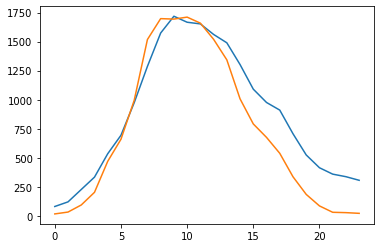

AttributeError: 'Model' object has no attribute 'save'

In [23]:
sensor_array.max()

8052

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107780 entries, 38656 to 4231014
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date_time      107780 non-null  datetime64[ns]
 1   hourly_counts  107780 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.5 MB


##### Now let's try different models:

In [137]:
#Now lets compare with other regression models...
from sklearn.ensemble import RandomForestRegressor

In [106]:
single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

single_sensor_climate.drop(['date_time_x', 'date_time_y','year', 'sensor_id', 'sensor_name'
                            , 'lat', 'lon', 'sensor_description', 'mdate'], axis = 1, inplace = True)

single_sensor_climate.fillna(method='ffill', inplace = True)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:15] = scaled[i][0:15]
    new_sequence[i][16] = scaled[i+1][3]

In [318]:
train = new_sequence[0:12000, :]
test = new_sequence[12001:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

In [319]:
RFR = RandomForestRegressor(n_estimators=350, min_samples_split = 20, min_samples_leaf = 20, max_depth=100, n_jobs= -1, max_features=50)
RFR.fit(train_x, train_y)
print("The Random Forest regressor's R-squared score: ", RFR.score(test_x, test_y))

The Random Forest regressor's R-squared score:  0.8965326945040334


In [321]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [322]:
# The GRU architecture
model_gru = Sequential()
# First GRU layer with Dropout regularisation
model_gru.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]), activation='tanh'))
model_gru.add(Dropout(0.2))
model.add(BatchNormalization())
# Second GRU layer
model_gru.add(GRU(units=75, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]), activation='tanh'))
model_gru.add(Dropout(0.2))
# Third GRU layer
model_gru.add(GRU(units=100, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]), activation='tanh'))
model_gru.add(Dropout(0.2))
# Fourth GRU layer
model_gru.add(GRU(units=125, activation='tanh'))
# model_gru.add(Dense(48, kernel_initializer='normal', activation='relu'))
# model_gru.add(Dropout(0.2))

# The output layer
model_gru.add(Dense(1))
# Compiling the RNN
model_gru.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.95, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
# model_gru.fit(X_train,y_train,epochs=50,batch_size=150)

H:\Anaconda\envs\SIT799_42\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [323]:
model_gru.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=1, batch_size = 64)

Epoch 1/500
188/188 [==============================] - 14s 28ms/step - loss: 0.0309 - val_loss: 0.0232
Epoch 2/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0301 - val_loss: 0.0230
Epoch 3/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0301 - val_loss: 0.0231
Epoch 4/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0299 - val_loss: 0.0237
Epoch 5/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0298 - val_loss: 0.0228
Epoch 6/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0297 - val_loss: 0.0228
Epoch 7/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0295 - val_loss: 0.0228
Epoch 8/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0294 - val_loss: 0.0231
Epoch 9/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0292 - val_loss: 0.0224
Epoch 10/500
188/188 [==============================] - 3s 16ms/step - loss: 0.02

188/188 [==============================] - 3s 16ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 160/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 161/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 162/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 163/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 164/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 165/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 166/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 167/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 168/500
188/188 [==============================] - 3s 16ms/step - loss: 

Epoch 238/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 239/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 240/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 241/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 242/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 243/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 244/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 245/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 246/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 247/500
188/188 [==============================] - 3s 16ms

Epoch 317/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 318/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 319/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 320/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 321/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 322/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 323/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 324/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 325/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 326/500
188/188 [==============================] - 3s 16ms

Epoch 396/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 397/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 398/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 399/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 400/500
188/188 [==============================] - 3s 18ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 401/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 402/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 403/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 404/500
188/188 [==============================] - 3s 16ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 405/500
188/188 [==============================] - 3s 16ms

Epoch 475/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 476/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 477/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 478/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 479/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 480/500
188/188 [==============================] - 3s 17ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 481/500
188/188 [==============================] - 3s 18ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 482/500
188/188 [==============================] - 3s 18ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 483/500
188/188 [==============================] - 3s 18ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 484/500
188/188 [==============================] - 3s 17ms

In [161]:
yhat = model_gru.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

R-squared score: 0.917


### For the next method, we'll use TBATS

In [ ]:
from tbats import BATS, TBATS

sensor_array = subset['hourly_counts'].to_numpy()

# create estimator with 24 hour (one day) and 168 hour (one week) seasonality
estimator = TBATS(seasonal_periods=[24, 168], use_arma_errors=True, use_box_cox=False, n_jobs=10 )

# Fit model
fitted_model = estimator.fit(sensor_array[100000:105000])

# forecast for the next 24 hours
y_forecasted = fitted_model.forecast(steps=24)

# print the AIC metric
print("AIC: ", fitted_model.aic)
print("")

y_actual = sensor_array[105000:105024]
plt.plot(y_forecasted)
plt.plot(y_actual)

### Then we can give Sarimax a try

In [106]:
# sar_set = subset.copy()
sar_set = subset.iloc[-10000:-1000].copy()

sar_set.index = sar_set.date_time
sar_set.drop(columns='date_time', inplace=True)

In [107]:
sar_set.index = pd.DatetimeIndex(sar_set.index).to_period('H')

In [108]:
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 24)

model = SARIMAX(endog=sar_set, order=my_order, seasonal_order=my_seasonal_order)

In [109]:
history = model.fit()
output = history.forecast()

In [110]:
output

2022-03-20 08:00    395.951427
Freq: H, dtype: float64

In [117]:
y_actual = subset.iloc[-1000:-976]

In [118]:
y_predicted = history.predict(start = 9000, end = 9024)

In [128]:
y_predicted[0:23]
# plt.plot(y_predicted)
# plt.plot(y_actual)

2022-03-20 08:00     395.951427
2022-03-20 09:00     735.279824
2022-03-20 10:00    1249.372483
2022-03-20 11:00    2034.111594
2022-03-20 12:00    2606.151391
2022-03-20 13:00    2908.265789
2022-03-20 14:00    2812.591920
2022-03-20 15:00    2846.803738
2022-03-20 16:00    2706.757302
2022-03-20 17:00    2771.629323
2022-03-20 18:00    2412.444445
2022-03-20 19:00    1859.357952
2022-03-20 20:00    1361.234582
2022-03-20 21:00    1167.184167
2022-03-20 22:00    1138.032288
2022-03-20 23:00     733.148648
2022-03-21 00:00     458.504848
2022-03-21 01:00     328.675867
2022-03-21 02:00     252.342994
2022-03-21 03:00     197.014446
2022-03-21 04:00     139.716258
2022-03-21 05:00     133.506424
2022-03-21 06:00     180.357149
Freq: H, Name: predicted_mean, dtype: float64

In [76]:
# model.save("model_5.h5")

##### What about if we adjust for seasonality?

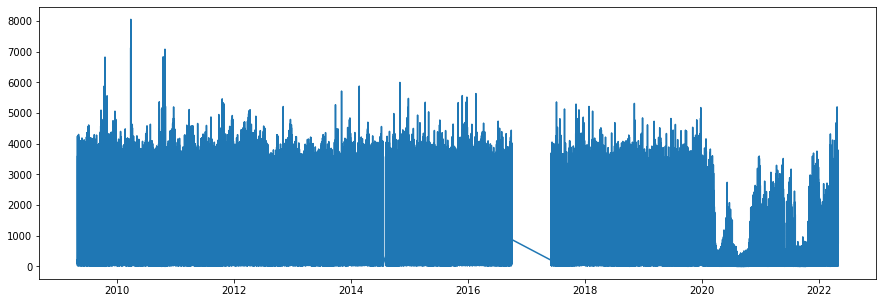

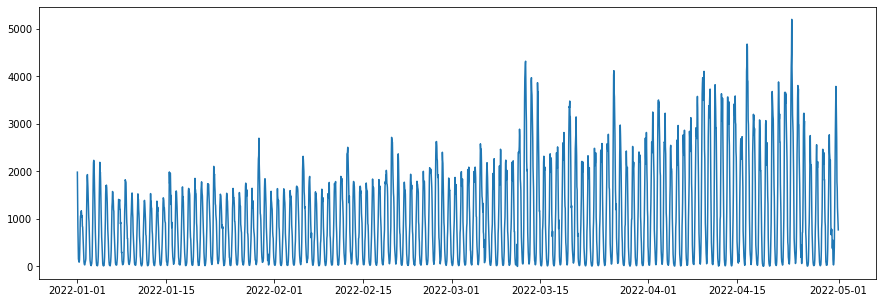

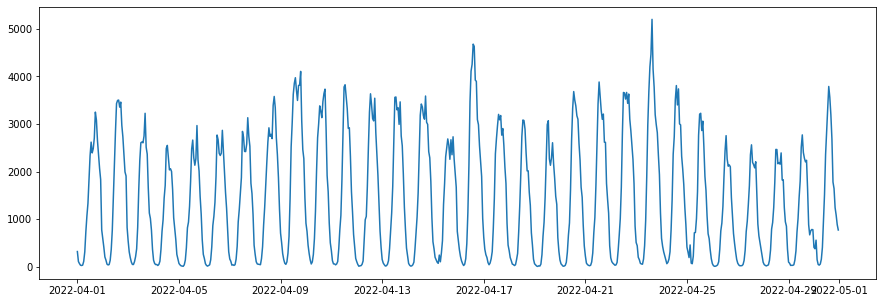

In [201]:
#Investigating seasonality
subset = single_sensor[['date_time', 'hourly_counts']].copy()
subset.date_time = pd.to_datetime(subset.date_time)
plt.figure(figsize = (15, 5))
plt.plot(subset.date_time, subset.hourly_counts)

subset = single_sensor[['date_time', 'hourly_counts']].copy()
sub = subset.loc[(subset.date_time > '2021-12-31T23:00:00.000')].copy()
sub.date_time = pd.to_datetime(sub.date_time)
plt.figure(figsize = (15, 5))
plt.plot(sub.date_time, sub.hourly_counts)

subset = single_sensor[['date_time', 'hourly_counts']].copy()
sub = subset.loc[(subset.date_time > '2022-03-31T23:00:00.000')].copy()
sub.date_time = pd.to_datetime(sub.date_time)
plt.figure(figsize = (15, 5))
plt.plot(sub.date_time, sub.hourly_counts)

In [129]:
res = seasonal_decompose(sar_set)
res.plot()

TypeError: PeriodIndex given. Check the `freq` attribute instead of using infer_freq.

In [30]:
single_sensor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107780 entries, 26 to 4231014
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date_time      107780 non-null  datetime64[ns]
 1   year           107780 non-null  int64         
 2   month          107780 non-null  object        
 3   mdate          107780 non-null  int64         
 4   day            107780 non-null  object        
 5   time           107780 non-null  int64         
 6   sensor_id      107780 non-null  int64         
 7   sensor_name    107780 non-null  object        
 8   hourly_counts  107780 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 8.2+ MB


In [24]:
single_sensor.date_time = pd.to_datetime(single_sensor.date_time)

In [25]:
single_sensor.set_index('date_time')

,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
date_time,,,,,,,,
2009-05-01 00:00:00,2009,May,1,Friday,0,4,Town Hall (West),0.025956
2009-05-01 01:00:00,2009,May,1,Friday,1,4,Town Hall (West),0.016393
2009-05-01 02:00:00,2009,May,1,Friday,2,4,Town Hall (West),0.007948
2009-05-01 03:00:00,2009,May,1,Friday,3,4,Town Hall (West),0.004471
2009-05-01 04:00:00,2009,May,1,Friday,4,4,Town Hall (West),0.005340
...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00,2022,April,30,Saturday,19,4,Town Hall (West),0.203800
2022-04-30 20:00:00,2022,April,30,Saturday,20,4,Town Hall (West),0.153875
2022-04-30 21:00:00,2022,April,30,Saturday,21,4,Town Hall (West),0.134501


In [28]:
single_sensor.sort_index(inplace=True)